# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [8]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [9]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [10]:
x = critics

In [11]:
len(x[~x.quote.notnull()])

0

In [12]:
len(critics[critics.quote.isnull()])

0

In [13]:
critics.columns

Index(['critic', 'fresh', 'imdb', 'publication', 'quote', 'review_date', 'rtid', 'title'], dtype='object')

In [14]:
critics.title.tolist().unique()

AttributeError: 'list' object has no attribute 'unique'

In [15]:
type(critics.title)

pandas.core.series.Series

In [16]:
critics.title.unique()

array(['Toy story', 'Jumanji', 'Grumpy Old Men', ...,
       'Et Dieu... créa la femme', 'Never Cry Wolf', 'A Raisin in the Sun'], dtype=object)

In [17]:
unique_values_titles = set(critics.title.tolist()) # To get a unique set of values from a list use set function. 

In [18]:
critics.title.unique().size

1921

### Explore

In [38]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


In [39]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'

In [40]:
df.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


15561
622
623
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
37
14
percent critics with reviews more than 100 and average freshness rating below 0.6: 37.83783783783784


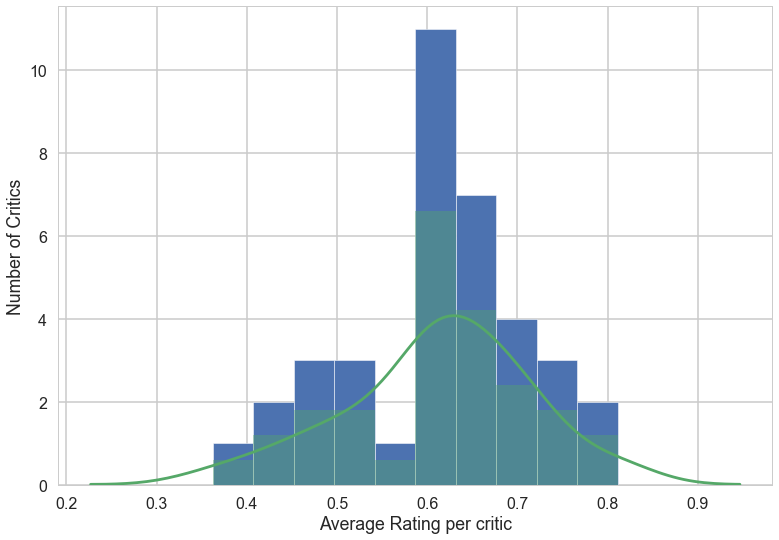

In [41]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')

counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

print(len(df))
print(len(grp))
print(len(df.critic.unique()))
import collections
collections.Counter(df.critic.unique())

#print(means[counts>100].value_counts())
#print(grp.head())
print(type(means[counts>100]))
print(type(df.critic.unique()))
a = means[counts>100]
print(a.count())
print(a[a<0.6].count())
print('percent critics with reviews more than 100 and average freshness rating below 0.6: {}'.format((a[a<0.6].count())/(a.count())*100))

means[counts >100].hist(bins=10, edgecolor='w', lw=0.5)
sns.distplot(means[counts>100], bins = 10)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [42]:
grped = df.groupby('critic').agg({'review_count':mean, 'mean_freshness':mean})
grped.head()

NameError: name 'mean' is not defined

---

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

<div class="span5 alert alert-info">
<h3>Answers Exercise Set I: </h3>

Majority of critics have average rating > 0.6. Percent critics with reviews more than 100 and average freshness rating below 0.6 is 37.8 which is also reflected by the left-skewed yet normal distribution.

This means that the movie critics very seldom give a rating below 0.6) or the movies sampled in the dataset are generally good movies. It would be helpful to compare critic rating with box office/audience sentiments


---

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

## Use CountVectorizer() to create *bag of words*
> #### An array of m x n: m = *d* or a document or a sentence and n = words (sorted alphabetically) 
>> ##### Every cell or value represents how many times that column which is a word appread in that document/row/sentence

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

# instantiate min_df ignores words that have a document freq. of occurance < min_df
vectorizer = CountVectorizer(min_df=0) 

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))
print('In simpler terms, this matrix reps: rows as doc/sentence and columns as alph-btly sorted volcab \
or all words across all sentences and the values are count of that word in that row/sentence')

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]
In simpler terms, this matrix reps: rows as doc/sentence and columns as alph-btly sorted volcab or all words across all sentences and the values are count of that word in that row/sentence

Words for each feature:
['hop', 'off', 'on', 'pop']


In [52]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    X = X.toarray()
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [53]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

---
<div class="span5 alert alert-info">
#### Check counts of the classification (1 and 0 in this case)

In [54]:
v = pd.Series(y)
print(v.value_counts()) # using value_counts requires converting np.array to pd.series
print(np.bincount(y)) # works only for numeric/int values

unique, counts = np.unique(y, return_counts=True) # better soln for int/char values
print(np.asarray((unique, counts)))

from scipy.stats import itemfreq
print(itemfreq(y))


1    9482
0    6079
dtype: int64
[6079 9482]
[[   0    1]
 [6079 9482]]
[[   0 6079]
 [   1 9482]]


<div class="span5 alert alert-info">

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [55]:
X=np.array(X)
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [56]:
#your turn
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics

# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
# clf = MultinomialNB()
# clf.fit(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print('training size: {}'.format((X_train.shape[0]/X.shape[0])*100))
print("test size: {}".format((X_test.shape[0]/X.shape[0])*100))

print('class training size: {}'.format(len(y_train)/len(y)))
print("class test size: {}".format(len(y_test)/len(y)))

mn_nb = MultinomialNB() # instantiate multinomial NB classifier with default attr's...
mn_nb.fit(X_train, y_train, sample_weight=None)
train_pred = mn_nb.predict(X_train)

training size: 69.99550157444895
test size: 30.004498425551056
class training size: 0.6999550157444895
class test size: 0.30004498425551057


In [57]:
X_train


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

<div class="span5 alert alert-info">
### Check multinom_NB attributes, coef and class, feature counts -->

In [58]:
print('multinomial NB coeficients:', mn_nb.coef_)
print('multinomial class counts:', mn_nb.class_count_)
print('multinomial feature counts:', mn_nb.feature_count_)
print('multinomial posterior prob:', mn_nb.predict_proba)
print('multinomial prior prob:', mn_nb.class_prior)
print('multinomial classes:', mn_nb.classes_)
    

multinomial NB coeficients: [[-10.8104415  -11.90905379 -10.8104415  ..., -10.8104415  -11.90905379
  -11.90905379]]
multinomial class counts: [ 4285.  6607.]
multinomial feature counts: [[ 3.  0.  2. ...,  1.  1.  1.]
 [ 2.  0.  2. ...,  2.  0.  0.]]
multinomial posterior prob: <bound method BaseNB.predict_proba of MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)>
multinomial prior prob: None
multinomial classes: [0 1]


<div class="span5 alert alert-info">
### Test the classifier on test data -->

In [59]:
mn_nb_prediction = mn_nb.predict(X_test)

<div class="span5 alert alert-info">
### Check accuracy -->

In [60]:
print('Accuracy score for MN NB classifier on training data: {:2.4f}%'\
      .format(accuracy_score(y_train, train_pred, )*100))
print('Accuracy score for MN NB classifier on test data: {:2.4f}%'\
      .format(accuracy_score(y_test, mn_nb_prediction)*100))
print('')
print('Classification report:\n {}'.format(metrics.classification_report(y_test, mn_nb_prediction)))
print('')
print('Confusion Matrix:\n {}'.format(metrics.confusion_matrix(y_test, mn_nb_prediction)))

Accuracy score for MN NB classifier on training data: 92.3338%
Accuracy score for MN NB classifier on test data: 77.8325%

Classification report:
              precision    recall  f1-score   support

          0       0.75      0.64      0.69      1794
          1       0.79      0.87      0.83      2875

avg / total       0.78      0.78      0.77      4669


Confusion Matrix:
 [[1144  650]
 [ 385 2490]]


In [61]:
print(mn_nb.get_params(deep=True))

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


<div class="span5 alert alert-info">
<h3>Exercise II Conclusion</h3>
Accuracy score for MN NB classifier on training data: 92.3338%
Accuracy score for MN NB classifier on test data: 77.8325%


With simple test train split evaluation the model seem to be slightly overfit.(training score = 92% vs test score = 77%)

Precision is a measure of how often your predictions for the positive class are actually true. It’s calculated as the number of True Positives (e.g. predicting an email is spam and it is actually spam) over the sum of the True Positives and False Positives (e.g. predicting an email is spam when it’s not).

Recall(also know as sensitivity or true positive rate) is the measure of how often the actual positive class is predicted as such. It’s calculated as the number of True Positives over the sum of the True Positives and False Negatives (e.g. predicting an email is not spam when it is).

##### Flase negative = 385/2490 = 15% seem to be hurting the recall rate so there is room for improvement !
##### With CV and regularization hypermaramter tuning which, for Multinomial NaiveBayes model is α: An additive smoothing parameter (α=1 for Laplace smoothing) the model performance can be improved. 

---

### Picking Hyperparameters for Naive Bayes and Text Maintenance

#### We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. 
As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [62]:
# Your turn.
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

## USe the function
X, y = make_xy(critics)

<div class="span5 alert alert-info">
### right now array X contains count of occurance of a word (which is a col) in a given row (which is a doc)
> ### what we need is count of words that appear across documents

In order to create a cdf of word count we need to convert the present X which is a mxn array to a similar dimension array where each cell is either 1 or 0 since we know that ea col is a word and ea row is a document. Then we can easily count how many times a word appeared "across all documents" by counting the 1's in each col. Since a value of 1 in any cell corresponds to occurance of that word in that document we need to sum up the columns to get a count of occurances of each word. 

### numpy.nonzero(a)    

    Return the indices of the elements that are non-zero.

    Returns a tuple of arrays, one for each dimension of a, containing the indices of the non-zero elements in that dimension

In [63]:
X_occurances = X.copy()
X_occurances[np.nonzero(X_occurances)]=1
X_occurances = X_occurances.toarray()
X_occurances.shape
X_count = X_occurances.sum(axis=0)
len(X_count)
X_count.max()

9502

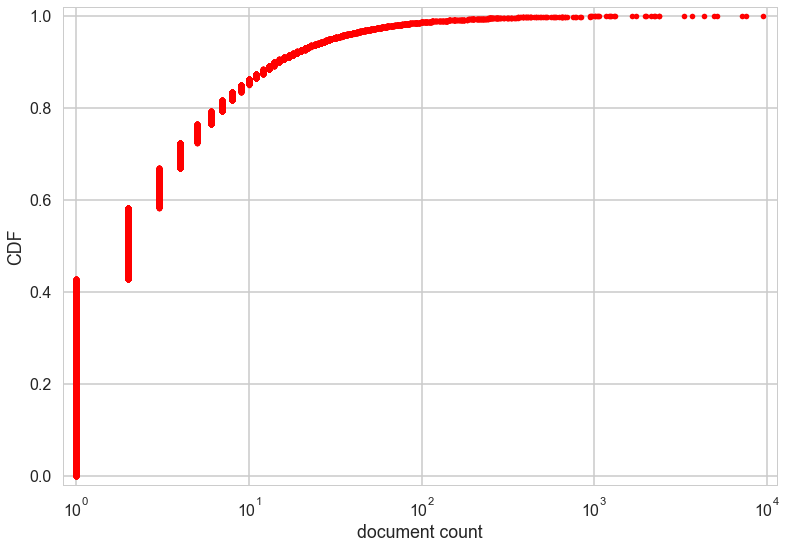

In [64]:
# CDF plot:
import matplotlib.pyplot as plt
x = np.sort(X_count)
y = np.arange(1, len(x)+1)/(len(x))
_ = plt.plot(x,y, marker = '.', linestyle = 'none', c = 'r')
_ = plt.xscale('log')
_ = plt.xlabel('document count')
_ = plt.ylabel('CDF')
plt.margins(0.02) # too keep data from running into plot edges
plt.show()

### min_df = 1 and max_df = 100

---

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [65]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [69]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [70]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Users/admin/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [71]:
range(critics.shape[0])

range(0, 15561)

In [72]:
print(critics.shape)
len(itest)

(15561, 8)


4669

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

ANSWER: The function log_likelihood is the logarithmic value of the probability of freshness or positive review

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

ANSWER: Since $\alpha$ is a smoothing parameter for Multinomial Naive Bayes classifier or in other words a regularization hyper-parameter for MN NB clf: with very large values of alpha, the classifier will be underfit, forcing the coefficients to very small values and will do a poor job at prediction.

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

In [73]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [0.1, 1, 10, 100]
best_min_df = [0.1,1,10,1000]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in best_min_df:
        '''Vectorization of text data...a pre-processing step'''
        vectorizer = CountVectorizer(min_df=min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis = Xthis[mask]
        ytrainthis = ythis[mask]
    
    # your turn
        
        clf = MultinomialNB(alpha=alpha)
        #scorefunc = log_likelihood(clf,Xtrainthis,ytrainthis) ###why sis this not working \
        # NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate \
        # arguments before using this method.
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, scorefunc = log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            final_alpha, final_min_df = alpha, min_df
            print("final_alpha:", final_alpha, 'final_min_df:', final_min_df, 'best_score:', maxscore)

final_alpha: 0.1 final_min_df: 0.1 best_score: -620.397244288
final_alpha: 1 final_min_df: 0.1 best_score: -620.384300712
final_alpha: 1 final_min_df: 10 best_score: -589.586497372


In [74]:
final_min_df, final_alpha

(10, 1)

# What's the significance of *Masking* here?
Generally though (say for things like scaling or other transforms) its best to first do the actual split and then the preprocssing on the training data --> with exact same transforms then applied to test data. 

But obviously for text data and getting word counts this might be more harmful as could lead you to end up with words just in the test data that the model would not know what to do with.  

## What Richie Ng says:
<b> Vectorize then split<b>

If we vectorize then we train/test split, our document-term matrix would contain every single feature (word) in the test and training sets
        * What we want is to simulate the real world
        * We would always see words we have not seen before so this method is not realistic and we cannot properly evaluate our models

<b> Split then vectorize (correct way)<b>

    We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words we have not seen before

<b> After you train your data and chose the best model, you would then train on all of your data before predicting actual future data to maximize learning. <b>

---

<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [ ]:
vectorizer = CountVectorizer(min_df=final_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=final_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [ ]:
### SCRATCH PAD ######
(clf.predict_log_proba(x)[:, 0]).shape
x = np.eye(xtest.shape[1])
x.shape
clf.predict_log_proba(x).shape

<b> predict_log_proba(X)<b>

    Return log-probability estimates for the test vector X.
    Parameters:	

    X : array-like, shape = [n_samples=documents/sentensec, n_features=words/cols in vectorized matrix]
    	
* assuming we are testing prob of a sample/sentence belonging to either of two classes {positive:1, negative:0}

Returns:
    C : array-like, shape = [n_samples=prob of samples i.e. each sentence {pos or neg}, n_classes]

        Returns the log-probability of the samples for each class in the model. The columns correspond to the classes in sorted order, as they appear in the attribute classes_.


In [ ]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) # how does it know which word is which feature? \
                            # Assumes same order of cols as original xtest cols?
probs = clf.predict_log_proba(x)[:, 0] # We are taking 1st col as the prob as sorted from col 0 to col 1. \
                                        # Col 0: pro of posivtive and Col 1: prob of negative
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [ ]:
probs

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

<b>Answer Set VI: The probability for each row in the identify matrix represents the prediction contribution of that one word to the overall classification of the given quote/review/document/row

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [ ]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [ ]:
#your turn

# vec = CountVectorizer(min_df=0)
# X_new = vec.fit_transform(['This movie is not remarkable, touching, or superb in any way'])

## We already have a trained best model from the best hyperparameter tuning selection\
## ...so we'll us the model on new review
## --> clf = MultinomialNB(alpha=final_alpha).fit(xtrain, ytrain)

# X_new = X_new.tocsc()


new_revw = ['This movie is not remarkable, touching, or superb in any way']
X_new = vectorizer.transform(new_revw)
X_new = X_new.tocsc()   
class_pred = clf.predict(X_new)
if class_pred == 1:
    print('classifier predicted the new review ["This movie is not remarkable, touching, or superb in any way"] as Fresh')
else:
    print('classifier predicted the new review ["This movie is not remarkable, touching, or superb in any way"] as Rotten')

print('Prediction probability:', clf.predict_proba(X_new))

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [ ]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

## BIGRAM USING NAIVE BAYES

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


In [ ]:
def make_xy_bigram(critics, bigram_vectorizer=None):
    #Your code here    
    if bigram_vectorizer is None:
        bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),token_pattern=r'\b\w+\b', min_df=1)
    X = bigram_vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1, stop_words='english')
X, y = make_xy_bigram(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

## Using bigram from nltk package

In [ ]:
import itertools
import pandas as pd
from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures
 
def bigram_word_feats(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(words, bigrams)])

In [ ]:
import collections
import nltk.classify.util, nltk.metrics
from nltk import precision, recall
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

pos_review = critics[critics['fresh']=='fresh']
neg_review = critics[critics['fresh']=='rotten']

negfeats = [(bigram_word_feats(row['quote'].split()),'neg') for index, row in neg_review.iterrows()]
posfeats = [(bigram_word_feats(row['quote'].split()),'pos') for index, row in pos_review.iterrows()]
    
negcutoff = int(len(negfeats)*.7)    
poscutoff = int(len(posfeats)*.7)       

trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]    
testfeats  = negfeats[negcutoff:] + posfeats[poscutoff:]    
 
classifier = NaiveBayesClassifier.train(trainfeats)    
refsets = collections.defaultdict(set)    
testsets = collections.defaultdict(set)    
 
for i, (feats, label) in enumerate(testfeats):    
        refsets[label].add(i)    
        observed = classifier.classify(feats)    
        testsets[observed].add(i)    
classifier.show_most_informative_features()

# Applying RANDOM FOREST classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean()

## word2vec or Latent Dirichlet Allocation to group words into topics and use those topics for prediction.

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

vectorizer = CountVectorizer(min_df=1)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

lda = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X)

print("\nTopics in LDA model:")
feature_names = vectorizer.get_feature_names()
print_top_words(lda, feature_names, n_top_words=20)



# TF-IDF weighting instead of word counts. 

In [ ]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X = Xtfidf.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB().fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))